## Image feature extraction

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import pickle
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import json
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import dgl.data
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

In [3]:
IMAGE_MODEL = 'inception'

In [4]:
# edges = pd.read_parquet(f'../processed/{IMAGE_MODEL}/edges.parquet')
# nodes = pd.read_parquet(f'../processed/{IMAGE_MODEL}/nodes.parquet',engine='pyarrow')
# sub_cat_coded_cols = list(nodes.filter(regex='sub').drop(columns='sub_cat').columns)
# node_features = torch.Tensor(nodes[['price']+sub_cat_coded_cols].to_numpy())
# # node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
# edges_src = torch.from_numpy(edges['asin'].to_numpy())
# edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())

# #Build Graph
# g = dgl.graph((edges_src, edges_dst))
# g.ndata['feat'] = node_features
# g
# # g.ndata['label'] = node_labels

In [44]:
def train_test_split(g,test_ratio = 0.1):
    # Split edge set for training and testing
    torch.manual_seed(0)
    np.random.seed(0)
    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    eids = np.random.permutation(eids)
    ## eids are the index of the dataframe representing each edge, with eids[:test_seze] we are defining that we need all edges in a datafarme
    ## whic has index < test_seze, thos should go in test
    # return eids

    test_size = int(len(eids) * test_ratio)
    train_size = g.number_of_edges() - test_size
    print(train_size,test_size)
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]
    # return train_pos_u, train_pos_v,test_pos_u, test_pos_v

    # Find all negative edges and split them for training and testing
    ## generating aXa matrix which hsows one if edge is present else 0
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())),shape=(g.number_of_nodes(),g.number_of_nodes()))

    ## adj.todense to keep only non existent
    ## np.eye to remove identlical edge liek (0,0), (1,1), (2,2)
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)
    np.random.seed(0)
    ## keeping only half negative samples
    neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // 2)
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
    train_g = dgl.remove_edges(g, eids[:test_size])
    test_g = dgl.remove_edges(g, eids[test_size:])
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())
    return train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

cuda:0
Num GPUs Available:  1


In [7]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [8]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [10]:
from mlflow import log_metric, log_param, log_artifact
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import roc_auc_score

from mlflow.tracking import MlflowClient


In [11]:
remote_server_uri = "http://127.0.0.1:5000/"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
experiment_name = 'Image_recommendation_v2'

mlflow.set_experiment(experiment_name)
# Forcing an end_run() to prevent 
#    https://github.com/mlflow/mlflow/issues/1335 
#    https://github.com/mlflow/mlflow/issues/608

mlflow.autolog()

artifact_path = mlflow.get_artifact_uri()
uri = mlflow.tracking.get_tracking_uri()
print(artifact_path)
print(uri)
mlflow.end_run()

2024/06/22 20:02:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/06/22 20:02:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/06/22 20:02:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/06/22 20:02:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/06/22 20:02:03 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This ini

mlflow-artifacts:/776806898356336235/039139807cb6463886eb2361fab8974f/artifacts
http://127.0.0.1:5000/


In [12]:
from mlflow.tracking import MlflowClient
client = MlflowClient(mlflow.get_tracking_uri())


In [13]:
def compute_loss(pos_score, neg_score):
            scores = torch.cat([pos_score, neg_score])
            labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
            return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [14]:
from umap.umap_ import UMAP

In [15]:
def process_data(image_model,image_included,umap_dt):
    edges = pd.read_parquet(f'../processed/{image_model}/edges.parquet')
    nodes = pd.read_parquet(f'../processed/{image_model}/nodes.parquet',engine='pyarrow')
    sub_cat_coded_cols = list(nodes.filter(regex='sub').drop(columns='sub_cat').columns)
    cols_needed = ['price']+sub_cat_coded_cols
    if image_included:
        if umap_dt:
            umap_reducer = UMAP(**umap_dt, random_state=7)
            reduced_image_vectors = umap_reducer.fit_transform(nodes.filter(regex='vec_'))
            nodes = pd.concat([nodes.filter(regex='^(?!vec_)'),pd.DataFrame(reduced_image_vectors,columns=[f'umap_{i}' for i in range(reduced_image_vectors.shape[1])],index=nodes.index)],axis=1)
            cols_needed += list(nodes.filter(regex='umap_').columns)
        else:
            cols_needed += list(nodes.filter(regex='vec_').columns)
    return nodes,edges,cols_needed

In [16]:
def get_top_k_new(graph, model, k=6):
    """
    Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    all_nodes = graph.nodes().numpy()
  

    recommendations = []
    for i in tqdm(all_nodes):
        link_scores = torch.matmul(node_embeddings[i], node_embeddings.t()).squeeze(0)
        top_k = torch.topk(link_scores, k).indices.numpy()
        recommendations.append(top_k)
    return pd.DataFrame({"node_id":all_nodes,'recommendations':recommendations})

In [17]:
def save_model(model, optimizer, path):
  """Saves the DGL model, weights, and optimizer to a specified path.

  Args:
      model (dgl.nn.Module): The DGL model to save.
      optimizer (torch.optim.Optimizer): The optimizer used for training (optional).
      path (str): The path to save the model and optimizer state.
  """
  model_state_dict = model.state_dict()
  if optimizer:
    optimizer_state_dict = optimizer.state_dict()
  else:
    optimizer_state_dict = None
  model_data = {
      'model_state': model_state_dict,
      'optimizer_state': optimizer_state_dict
  }
  torch.save(model_data, path)

In [18]:
def get_recommendation_from_graph(graph,model,k):
    edges_g = graph.edges()
    edges_g = pd.DataFrame({'asin':edges_g[0].tolist(),'also_buy':edges_g[1].tolist()})
    true_val_ = edges_g.groupby('asin').also_buy.apply(lambda x: list(x))
    true_val_.index.name = 'node_id'
    scores = get_top_k_new(graph,model,k=k)
    scores_edges = pd.merge(true_val_ , scores, on='node_id')
    return scores_edges

In [29]:
def create_model_data(image_model,image_included = False,split_ratio =0.3,umap_dt=None):
    # edges = pd.read_parquet(f'../processed/{image_model}/edges.parquet')
    # nodes = pd.read_parquet(f'../processed/{image_model}/nodes.parquet',engine='pyarrow')
    # sub_cat_coded_cols = list(nodes.filter(regex='sub').drop(columns='sub_cat').columns)
    # cols_needed = ['price']+sub_cat_coded_cols
    # if image_included:
    #     cols_needed += list(nodes.filter(regex='vec_').columns)
    # print('node features',len(cols_needed))
    nodes,edges,cols_needed = process_data(image_model,image_included,umap_dt)
    node_features = torch.Tensor(nodes[cols_needed].to_numpy())
    # node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
    edges_src = torch.from_numpy(edges['asin'].to_numpy())
    edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())
    
    #Build Graph
    g = dgl.graph((edges_src, edges_dst))
    g.ndata['feat'] = node_features
    # g,nodes,edges = generate_graph(df_full[df_full.asin.isin(final_list)],include_img=True)
    train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,train_neg_g,test_pos_g,test_neg_g = train_test_split(g,split_ratio)

    return g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,test_pos_g,train_neg_g,test_neg_g,cols_needed

In [30]:
def train_model(image_model,run_name,n_epochs,image_included = False,split_ratio =0.3,lr=0.001,umap_dt=None,k=100,hidden_layers = 16):
    with mlflow.start_run(run_name=run_name) as run:
        
        g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,test_pos_g,train_neg_g,test_neg_g,cols_needed = create_model_data(image_model,image_included,split_ratio,umap_dt)

        ## M
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_layers)
        # You can replace DotPredictor with MLPPredictor.
        #pred = MLPPredictor(16)
        pred = DotPredictor()

        # ----------- 3. set up loss and optimizer -------------- #
        # in this case, loss will in training loop
        torch.manual_seed(0)
        optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=lr)

        # ----------- 4. training -------------------------------- #
        all_logits = []
        torch.manual_seed(0)
        for e in range(n_epochs):
            # forward
            model.train()
            h = model(train_g, train_g.ndata['feat'])
            pos_score = pred(train_pos_g, h)
            neg_score = pred(train_neg_g, h)
            loss = compute_loss(pos_score, neg_score)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if e % 5 == 0:
                print('In epoch {}, loss: {}'.format(e, loss))

        # ----------- 5. check results ------------------------ #
        torch.manual_seed(0)
        with torch.no_grad():
            pos_score = pred(train_pos_g, h)
            neg_score = pred(train_neg_g, h)
            auc_train_score = compute_auc(pos_score, neg_score)
        
        
        torch.manual_seed(0)
        with torch.no_grad():
            model.eval()
            h_test = model(test_g, test_g.ndata['feat'])
            pos_score = pred(test_pos_g, h_test)
            neg_score = pred(test_neg_g, h_test)
            auc_score = compute_auc(pos_score, neg_score)

        print('Train AUC', auc_train_score)
        print('Test AUC', auc_score)
        mlflow.set_tag("model_name", run_name)
        mlflow.log_param("train_split", split_ratio)
        mlflow.log_param("n_epochs", n_epochs)
        mlflow.log_param("lr", lr)
        mlflow.log_param("nodes", nodes[cols_needed].shape)
        mlflow.log_param("edges", edges.shape)
        if umap_dt:
            mlflow.log_params(umap_dt)
        torch.save(g, 'graph.pkl')
        mlflow.log_artifact('./graph.pkl')

        torch.save(train_g, 'train_g.pkl')
        mlflow.log_artifact('./train_g.pkl')
        torch.save(train_pos_g, 'train_pos_g.pkl')
        mlflow.log_artifact('./train_pos_g.pkl')
        torch.save(train_neg_g, 'train_neg_g.pkl')
        mlflow.log_artifact('./train_neg_g.pkl')
        
        torch.save(test_g, 'test_g.pkl')
        mlflow.log_artifact('./test_g.pkl')
        torch.save(test_pos_g, 'test_pos_g.pkl')
        mlflow.log_artifact('./test_pos_g.pkl')
        torch.save(test_neg_g, 'test_neg_g.pkl')
        mlflow.log_artifact('./test_neg_g.pkl')

        scores_test = get_recommendation_from_graph(test_g,model,k)
        scores_train = get_recommendation_from_graph(train_g,model,k)

        recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
        recall_train = scores_train.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()

        print(f'Train recall@{k}', recall_train)
        print(f'Test recall@{k}', recall_test)
        mlflow.log_metrics({f'recall_train_at_{k}':recall_train,f'recall_test_at_{k}':recall_test})
        # mlflow.log_input(nodes[cols_needed].head(), context="training")
        # mlflow.log_artifact("graph", g)
        mlflow.log_param("image_data_included",image_included )
        mlflow.log_metrics({'AUC_train': auc_train_score, 'AUC_test': auc_score})
        # Save model to artifacts
        torch.save(model, 'model.pkl')
        mlflow.log_artifact('./model.pkl')
        
        save_model(model,optimizer,'./model.pt')
        # Save the dictionary to a file using torch.save
        mlflow.log_artifact('./model.pt')
    return model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g
    

In [22]:
# def calculate_recall_at_k(k):
#     all_nodes =   # List of all nodes in the graph
#     recall_list = []

#     for node in all_nodes:
#         predicted_links = predict_links(node, k)  # List of (node, score) tuples
#         true_links = get_true_links(node)

#         # Extract just the nodes from the predicted links
#         predicted_nodes = [link[0] for link in predicted_links]

#         # Calculate the number of true positives in the top k predictions
#         true_positives = len(set(predicted_nodes) & set(true_links))

#         # Calculate recall
#         if len(true_links) > 0:
#             recall = true_positives / len(true_links)
#         else:
#             recall = 0

#         recall_list.append(recall)

#     # Calculate the average recall across all nodes
#     avg_recall_at_k = np.mean(recall_list)
#     return avg_recall_at_k

In [23]:
nodes = pd.read_parquet(f'../processed/{IMAGE_MODEL}/nodes.parquet',engine='pyarrow')
edges = pd.read_parquet(f'../processed/{IMAGE_MODEL}/edges.parquet',engine='pyarrow')
umap_dt = {'n_components':10}

## Without using any image data

In [26]:
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(image_model=IMAGE_MODEL,
                                                                                                                                          run_name=f'base_model',
                                                                                                                                          n_epochs=1000,
                                                                                                                                          image_included=False,
                                                                                                                                          split_ratio=0.3)

136163 58355
In epoch 0, loss: 179.7462615966797
In epoch 5, loss: 145.5391082763672
In epoch 10, loss: 117.09578704833984
In epoch 15, loss: 93.89742279052734
In epoch 20, loss: 75.30014038085938
In epoch 25, loss: 63.64959716796875
In epoch 30, loss: 55.98685073852539
In epoch 35, loss: 49.81108856201172
In epoch 40, loss: 43.7464485168457
In epoch 45, loss: 38.38261032104492
In epoch 50, loss: 34.005226135253906
In epoch 55, loss: 30.70394515991211
In epoch 60, loss: 27.49625015258789
In epoch 65, loss: 24.6951904296875
In epoch 70, loss: 22.34828758239746
In epoch 75, loss: 20.121362686157227
In epoch 80, loss: 18.377422332763672
In epoch 85, loss: 16.77037239074707
In epoch 90, loss: 15.383048057556152
In epoch 95, loss: 14.168095588684082
In epoch 100, loss: 13.099796295166016
In epoch 105, loss: 12.193639755249023
In epoch 110, loss: 11.388707160949707
In epoch 115, loss: 10.665704727172852
In epoch 120, loss: 10.014143943786621
In epoch 125, loss: 9.413496971130371
In epoch 130

100%|██████████| 30660/30660 [00:05<00:00, 5377.89it/s]


Train recall@100 0.02010694460496843
Test recall@100 0.02302780679177008


## Using Image Data but without dimensionality reduction ( UMAP )

In [25]:
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(image_model=IMAGE_MODEL,
                                                                                                                                          run_name=f'{IMAGE_MODEL}_image_data',
                                                                                                                                          n_epochs=7000,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt=None)

136163 58355


KeyboardInterrupt: 

## Using Image Data along with dimensionality reduction ( UMAP )

In [28]:
IMAGE_MODEL = 'inception'
model,g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g = train_model(image_model=IMAGE_MODEL,
                                                                                                                                          run_name=f'{IMAGE_MODEL}_image_data_umap',
                                                                                                                                          n_epochs=7000,
                                                                                                                                          image_included=True,
                                                                                                                                          split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3})

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


136163 58355
In epoch 0, loss: 227.6825714111328
In epoch 5, loss: 56.94511413574219
In epoch 10, loss: 27.72803497314453
In epoch 15, loss: 20.731046676635742
In epoch 20, loss: 14.113118171691895
In epoch 25, loss: 10.064653396606445
In epoch 30, loss: 8.253092765808105
In epoch 35, loss: 7.355205535888672
In epoch 40, loss: 6.496098518371582
In epoch 45, loss: 5.787513732910156
In epoch 50, loss: 5.254919052124023
In epoch 55, loss: 4.832662105560303
In epoch 60, loss: 4.468819618225098
In epoch 65, loss: 4.161630630493164
In epoch 70, loss: 3.8958206176757812
In epoch 75, loss: 3.659477472305298
In epoch 80, loss: 3.4572999477386475
In epoch 85, loss: 3.28273606300354
In epoch 90, loss: 3.1273398399353027
In epoch 95, loss: 2.9863438606262207
In epoch 100, loss: 2.8577136993408203
In epoch 105, loss: 2.7405900955200195
In epoch 110, loss: 2.630878210067749
In epoch 115, loss: 2.527588129043579
In epoch 120, loss: 2.4295029640197754
In epoch 125, loss: 2.335458993911743
In epoch 130

100%|██████████| 30660/30660 [00:06<00:00, 4777.59it/s]


Train recall@100 0.011546003546231833
Test recall@100 0.015857684236413573


In [31]:
g,nodes,edges,train_pos_u, train_pos_v,test_pos_u, test_pos_v,train_neg_u, train_neg_v,test_neg_u, test_neg_v,train_g,test_g,train_pos_g,test_pos_g,train_neg_g,test_neg_g,cols_needed = create_model_data('inception',image_included=True,split_ratio=0.3,umap_dt={'n_components':100,'n_neighbors':50,'min_dist':0.3})

c:\Users\Kartik\anaconda3\envs\tf\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


136163 58355


In [39]:
train_g,test_g

(Graph(num_nodes=30660, num_edges=136163,
       ndata_schemes={'feat': Scheme(shape=(249,), dtype=torch.float32)}
       edata_schemes={}),
 Graph(num_nodes=30660, num_edges=58355,
       ndata_schemes={'feat': Scheme(shape=(249,), dtype=torch.float32)}
       edata_schemes={}))

In [45]:
train2_pos_u, train2_pos_v,val_pos_u, val_pos_v,train2_neg_u, train2_neg_v,val_neg_u, val_neg_v,train2_g,val_g,train2_pos_g,train2_neg_g,val_pos_g,val_neg_g = train_test_split(train_g,0.2)

108931 27232


In [54]:
class GraphSAGE_2(nn.Module):
  def __init__(self, in_feats, h_feats,agg_func,dropout):  # in_feats and h_feats are required parameters
    super(GraphSAGE_2, self).__init__()
    self.conv1 = SAGEConv(in_feats, h_feats, aggregator_type = agg_func,feat_drop =dropout)  # Create a SAGEConv layer with specific parameters
    self.conv2 = SAGEConv(h_feats, h_feats, aggregator_type = agg_func,feat_drop =dropout)  # Create another SAGEConv layer with specific parameters

  def forward(self, g, in_feat):
    h = self.conv1(g, in_feat)  # Apply first convolution layer
    h = F.relu(h)  # Apply ReLU activation
    h = self.conv2(g, h)  # Apply second convolution layer
    return h

In [55]:
def create_model(in_feats, hidden_size = 16, aggregator='mean', dropout = 0):
  model = GraphSAGE_2(in_feats=in_feats,h_feats=hidden_size,agg_func=aggregator,dropout=dropout)
  return model

## Hyper tune model


In [42]:
import optuna


In [ ]:
## {'learning_rate': 0.0006386453866667889, 'hidden_dim': 16, 'dropout_rate': 0.3534978009009603, 'aggregator': 'pool'}

In [61]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [67]:
# num_epochs = 5000
def objective(params):
    h_feats = int(params['h_feats'])
    dropout = params['dropout']
    lr = params['lr']
    aggregator_type = params['aggregator_type']
    num_epochs = params['n_epochs']
    model = create_model(g.ndata["feat"].shape[1], h_feats, aggregator_type, dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    pred = DotPredictor()
    for epoch in range(num_epochs):
        # forward
        model.train()
        h = model(train2_g, train2_g.ndata['feat'])
        pos_score = pred(train2_pos_g, h)
        neg_score = pred(train2_neg_g, h)
        loss = compute_loss(pos_score, neg_score)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print('In epoch {}, loss: {}'.format(epoch, loss))
    
    scores_test = get_recommendation_from_graph(val_g,model,100)
    recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
    
    # return recall_test
    print(params)
    return {'loss': -recall_test, 'status': STATUS_OK}
space = {
    'h_feats': scope.int(hp.quniform('h_feats', 16, 128, 16)),
    'dropout': hp.uniform('dropout', 0, 0.5),
    'lr': hp.loguniform('lr', -5, -2),
    'aggregator_type': hp.choice('aggregator_type', ['mean', 'pool', 'lstm', 'gcn']),
    'n_epochs': scope.int(hp.quniform('n_epochs', 20, 100, 10))
}
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,
            rstate=np.random.default_rng(42))
print("Best hyperparameters:", best)

In epoch 0, loss: 20023.61328125                      
In epoch 20, loss: 0.7994781136512756                 
In epoch 40, loss: 0.9914823174476624                 
In epoch 60, loss: 0.9862105250358582                 
In epoch 80, loss: 0.9420211315155029                 
  0%|          | 0/50 [00:10<?, ?trial/s, best loss=?]

100%|##########| 30660/30660 [00:06<00:00, 4752.13it/s]


{'aggregator_type': 'pool', 'dropout': 0.32587119987444696, 'h_feats': 112, 'lr': 0.04329825231752766, 'n_epochs': 90}
In epoch 0, loss: 1003.8112182617188                                                
In epoch 20, loss: 0.7228009104728699                                               
  2%|▏         | 1/50 [00:19<14:48, 18.14s/trial, best loss: -0.0026154589371980676]

100%|##########| 30660/30660 [00:06<00:00, 4464.29it/s]


{'aggregator_type': 'gcn', 'dropout': 0.029968094540700263, 'h_feats': 112, 'lr': 0.04178355184232635, 'n_epochs': 40}
In epoch 0, loss: 713.1765747070312                                                 
In epoch 20, loss: 1.1772563457489014                                               
  4%|▍         | 2/50 [05:07<10:30, 13.13s/trial, best loss: -0.0026154589371980676]

100%|##########| 30660/30660 [00:06<00:00, 4602.34it/s]


{'aggregator_type': 'lstm', 'dropout': 0.07858985028094856, 'h_feats': 80, 'lr': 0.00840425693396495, 'n_epochs': 30}
In epoch 0, loss: 879.036376953125                                                    
In epoch 20, loss: 1.1159083843231201                                                 
In epoch 40, loss: 0.7903948426246643                                                 
  6%|▌         | 3/50 [06:49<2:21:29, 180.64s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:06<00:00, 4825.20it/s]


{'aggregator_type': 'gcn', 'dropout': 0.35223000813752336, 'h_feats': 80, 'lr': 0.012735668879258876, 'n_epochs': 50}
In epoch 0, loss: 1689.736083984375                                                   
In epoch 20, loss: 3.0680716037750244                                                 
In epoch 40, loss: 1.747151494026184                                                  
  8%|▊         | 4/50 [06:58<1:26:27, 112.77s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:05<00:00, 5246.42it/s]


{'aggregator_type': 'mean', 'dropout': 0.17305929881725102, 'h_feats': 48, 'lr': 0.00900418271974394, 'n_epochs': 60}
In epoch 0, loss: 14905.349609375                                                     
In epoch 20, loss: 2.7874186038970947                                              
In epoch 40, loss: 1.3769445419311523                                              
In epoch 60, loss: 0.8993449807167053                                              
 10%|█         | 5/50 [07:10<56:23, 75.19s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:05<00:00, 5250.63it/s]


{'aggregator_type': 'pool', 'dropout': 0.36157396222211435, 'h_feats': 64, 'lr': 0.010922529741911173, 'n_epochs': 80}
In epoch 0, loss: 602.127685546875                                                 
In epoch 20, loss: 1.6431697607040405                                              
In epoch 40, loss: 1.4958555698394775                                              
In epoch 60, loss: 0.9031070470809937                                              
 12%|█▏        | 6/50 [07:20<39:51, 54.36s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:05<00:00, 5505.96it/s]


{'aggregator_type': 'gcn', 'dropout': 0.434677958142653, 'h_feats': 32, 'lr': 0.1341175841295217, 'n_epochs': 80}
In epoch 0, loss: 2689.00927734375                                                 
In epoch 20, loss: 2.575503349304199                                               
 14%|█▍        | 7/50 [07:28<28:05, 39.20s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:06<00:00, 4682.88it/s]


{'aggregator_type': 'mean', 'dropout': 0.16848986962255413, 'h_feats': 96, 'lr': 0.08129009497450328, 'n_epochs': 30}
In epoch 0, loss: 166.76910400390625                                               
In epoch 20, loss: 0.9796730875968933                                              
In epoch 40, loss: 0.6399102210998535                                              
In epoch 60, loss: 0.5933089852333069                                              
 16%|█▌        | 8/50 [07:36<20:36, 29.44s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:04<00:00, 6210.47it/s]


{'aggregator_type': 'gcn', 'dropout': 0.28673048470873264, 'h_feats': 16, 'lr': 0.06816271617890228, 'n_epochs': 80}
In epoch 0, loss: 5552.01416015625                                                 
In epoch 20, loss: 0.8850131034851074                                              
In epoch 40, loss: 0.7138985991477966                                              
 18%|█▊        | 9/50 [07:46<15:21, 22.46s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [00:05<00:00, 5587.89it/s]


{'aggregator_type': 'pool', 'dropout': 0.35206702845306526, 'h_feats': 64, 'lr': 0.0284864001343566, 'n_epochs': 50}
In epoch 0, loss: 661.2783203125                                                    
 20%|██        | 10/50 [08:00<12:31, 18.79s/trial, best loss: -0.029247101449275364]

100%|##########| 30660/30660 [24:30<00:00, 20.84it/s]


{'aggregator_type': 'lstm', 'dropout': 0.4773902233445454, 'h_feats': 48, 'lr': 0.007625793259345788, 'n_epochs': 20}
In epoch 0, loss: 8159.30859375                                                       
In epoch 20, loss: 0.595332682132721                                                  
In epoch 40, loss: 0.5961012840270996                                                 
In epoch 60, loss: 0.5904672145843506                                                 
 22%|██▏       | 11/50 [35:53<5:41:38, 525.61s/trial, best loss: -0.04846764636329854]

100%|##########| 30660/30660 [00:05<00:00, 5412.50it/s]


{'aggregator_type': 'pool', 'dropout': 0.15390229944946937, 'h_feats': 32, 'lr': 0.04177142251006077, 'n_epochs': 80}
In epoch 0, loss: 811.1490478515625                                                   
In epoch 20, loss: 0.9581157565116882                                                 
 24%|██▍       | 12/50 [36:02<3:54:11, 369.78s/trial, best loss: -0.04846764636329854]

100%|##########| 30660/30660 [00:07<00:00, 4348.35it/s]


{'aggregator_type': 'gcn', 'dropout': 0.10843483792853714, 'h_feats': 80, 'lr': 0.060212145235736494, 'n_epochs': 40}
In epoch 0, loss: 610.8866577148438                                                   
In epoch 20, loss: 0.4996906816959381                                                 
 26%|██▌       | 13/50 [40:43<2:40:34, 260.39s/trial, best loss: -0.04846764636329854]

100%|##########| 30660/30660 [00:06<00:00, 5079.00it/s]


{'aggregator_type': 'lstm', 'dropout': 0.4410499053490562, 'h_feats': 32, 'lr': 0.027363252852314193, 'n_epochs': 30}
In epoch 0, loss: 333.9562683105469                                                   
In epoch 20, loss: 0.5019595623016357                                                 
 28%|██▊       | 14/50 [44:48<2:53:52, 289.79s/trial, best loss: -0.10404868247694334]

100%|##########| 30660/30660 [00:06<00:00, 4957.31it/s]


{'aggregator_type': 'lstm', 'dropout': 0.4869739733232261, 'h_feats': 16, 'lr': 0.10199769203135696, 'n_epochs': 40}
In epoch 0, loss: 1495.2650146484375                                                  
In epoch 20, loss: 1.988175630569458                                                 
In epoch 40, loss: 2.508267879486084                                                 
In epoch 60, loss: 2.290269374847412                                                 
In epoch 80, loss: 1.9518214464187622                                                
 30%|███       | 15/50 [47:07<2:50:15, 291.88s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:05<00:00, 5512.04it/s]


{'aggregator_type': 'mean', 'dropout': 0.16743004719404048, 'h_feats': 32, 'lr': 0.13044698706760605, 'n_epochs': 90}
In epoch 0, loss: 3233.578125                                                        
In epoch 20, loss: 2.853774070739746                                                 
In epoch 40, loss: 3.7371132373809814                                                
In epoch 60, loss: 3.650716781616211                                                 
In epoch 80, loss: 3.379194498062134                                                 
 32%|███▏      | 16/50 [47:18<1:57:07, 206.68s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:06<00:00, 4781.10it/s]


{'aggregator_type': 'mean', 'dropout': 0.2258128479235475, 'h_feats': 112, 'lr': 0.07747890310677927, 'n_epochs': 90}
In epoch 0, loss: 596.2301025390625                                                  
In epoch 20, loss: 1.8936915397644043                                                
In epoch 40, loss: 0.7913511395454407                                                
 34%|███▍      | 17/50 [47:27<1:21:33, 148.28s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:05<00:00, 5633.93it/s]


{'aggregator_type': 'gcn', 'dropout': 0.4882626520810925, 'h_feats': 48, 'lr': 0.009179763826969556, 'n_epochs': 50}
In epoch 0, loss: 292.1016540527344                                                  
In epoch 20, loss: 0.5433995127677917                                              
 36%|███▌      | 18/50 [6:56:05<56:29, 105.93s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:05<00:00, 5518.73it/s]


{'aggregator_type': 'lstm', 'dropout': 0.2085813440926868, 'h_feats': 32, 'lr': 0.08625603790455491, 'n_epochs': 40}
In epoch 0, loss: 3225.59912109375                                                       
In epoch 20, loss: 1.5539538860321045                                                    
In epoch 40, loss: 1.9942048788070679                                                    
 38%|███▊      | 19/50 [6:58:37<58:12:46, 6760.20s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:07<00:00, 4270.72it/s]


{'aggregator_type': 'mean', 'dropout': 0.1149178980045017, 'h_feats': 128, 'lr': 0.05721916207093111, 'n_epochs': 60}
In epoch 0, loss: 612.1224975585938                                                      
 40%|████      | 20/50 [6:58:54<39:27:06, 4734.22s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [00:05<00:00, 5116.54it/s]


{'aggregator_type': 'lstm', 'dropout': 0.4239172134235746, 'h_feats': 16, 'lr': 0.01798950384794459, 'n_epochs': 20}
In epoch 0, loss: 573.2830810546875                                                      
In epoch 20, loss: 0.4960877597332001                                                    
 42%|████▏     | 21/50 [8:39:38<27:26:46, 3407.12s/trial, best loss: -0.1063881579772884]

100%|##########| 30660/30660 [01:07<00:00, 454.21it/s]


{'aggregator_type': 'lstm', 'dropout': 0.42051995958759714, 'h_feats': 16, 'lr': 0.022254491166903718, 'n_epochs': 30}
In epoch 0, loss: 189.19760131835938                                                      
 44%|████▍     | 22/50 [8:45:04<32:38:19, 4196.43s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4852.79it/s]


{'aggregator_type': 'lstm', 'dropout': 0.4016177295972385, 'h_feats': 16, 'lr': 0.019404027010391463, 'n_epochs': 20}
In epoch 0, loss: 235.3140411376953                                                       
In epoch 20, loss: 0.49392369389533997                                                    
 46%|████▌     | 23/50 [8:58:26<22:47:24, 3038.68s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 5038.32it/s]


{'aggregator_type': 'lstm', 'dropout': 0.48699421949707, 'h_feats': 16, 'lr': 0.02031663254930347, 'n_epochs': 30}
In epoch 0, loss: 457.9219055175781                                                       
In epoch 20, loss: 0.592548668384552                                                      
 48%|████▊     | 24/50 [9:06:18<16:39:11, 2305.81s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4854.38it/s]


{'aggregator_type': 'lstm', 'dropout': 0.2895949672003902, 'h_feats': 48, 'lr': 0.018875896907659364, 'n_epochs': 30}
In epoch 0, loss: 231.2489013671875                                                       
 50%|█████     | 25/50 [9:08:12<12:11:44, 1756.19s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4571.85it/s]


{'aggregator_type': 'lstm', 'dropout': 0.38824782188444795, 'h_feats': 16, 'lr': 0.015335715586301151, 'n_epochs': 20}
In epoch 0, loss: 763.876953125                                                           
In epoch 20, loss: 0.5327333211898804                                                     
In epoch 40, loss: 0.4986669421195984                                                     
In epoch 60, loss: 0.4910246431827545                                                     
 52%|█████▏    | 26/50 [9:47:00<11:22:11, 1705.49s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4527.02it/s]


{'aggregator_type': 'lstm', 'dropout': 0.46639341495944137, 'h_feats': 64, 'lr': 0.024097053141496422, 'n_epochs': 70}
In epoch 0, loss: 504.421630859375                                                        
In epoch 20, loss: 0.527472734451294                                                     
 54%|█████▍    | 27/50 [9:56:10<9:14:24, 1446.28s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4669.03it/s]


{'aggregator_type': 'lstm', 'dropout': 0.30110462561250717, 'h_feats': 32, 'lr': 0.03225438681299107, 'n_epochs': 30}
In epoch 0, loss: 822.0221557617188                                                      
In epoch 20, loss: 0.6834713816642761                                                    
In epoch 40, loss: 0.5677804350852966                                                     
 56%|█████▌    | 28/50 [10:06:38<7:10:03, 1172.90s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 4493.82it/s]


{'aggregator_type': 'lstm', 'dropout': 0.3934149920502579, 'h_feats': 96, 'lr': 0.03500937021325696, 'n_epochs': 50}
In epoch 0, loss: 3012.366943359375                                                       
In epoch 20, loss: 0.6116587519645691                                                     
In epoch 40, loss: 0.5888304114341736                                                     
In epoch 60, loss: 0.5868997573852539                                                     
 58%|█████▊    | 29/50 [10:08:18<5:55:00, 1014.30s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:05<00:00, 5217.81it/s]


{'aggregator_type': 'pool', 'dropout': 0.25507981473133146, 'h_feats': 16, 'lr': 0.022822539711296656, 'n_epochs': 70}
In epoch 0, loss: 762.5540161132812                                                       
In epoch 20, loss: 0.7149786353111267                                                    
 60%|██████    | 30/50 [10:14:30<3:57:53, 713.70s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:06<00:00, 5021.50it/s]


{'aggregator_type': 'lstm', 'dropout': 0.31897813250896995, 'h_feats': 48, 'lr': 0.014487877592714358, 'n_epochs': 40}
In epoch 0, loss: 1621.2537841796875                                                     
In epoch 20, loss: 6.044922351837158                                                     
 62%|██████▏   | 31/50 [10:25:46<3:51:10, 730.04s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 3936.94it/s]


{'aggregator_type': 'lstm', 'dropout': 0.49251600240974047, 'h_feats': 128, 'lr': 0.047619519262048084, 'n_epochs': 30}
In epoch 0, loss: 1496.2794189453125                                                      
 64%|██████▍   | 32/50 [11:08:14<6:46:24, 1354.70s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4139.09it/s]


{'aggregator_type': 'lstm', 'dropout': 0.014921672900541999, 'h_feats': 96, 'lr': 0.010699374988482486, 'n_epochs': 20}
In epoch 0, loss: 15509.60546875                                                          
In epoch 20, loss: 0.8410404324531555                                                     
 66%|██████▌   | 33/50 [11:12:37<4:51:34, 1029.11s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:05<00:00, 5670.74it/s]


{'aggregator_type': 'pool', 'dropout': 0.45313461050761705, 'h_feats': 32, 'lr': 0.03879974068029846, 'n_epochs': 40}
In epoch 0, loss: 1262.0240478515625                                                      
In epoch 20, loss: 0.7640824317932129                                                    
In epoch 40, loss: 0.5019001960754395                                                    
In epoch 60, loss: 0.5005367398262024                                                    
In epoch 80, loss: 0.476214736700058                                                     
 68%|██████▊   | 34/50 [12:03:28<3:12:51, 723.21s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4154.50it/s]


{'aggregator_type': 'lstm', 'dropout': 0.37394743667446706, 'h_feats': 64, 'lr': 0.012545336693230375, 'n_epochs': 100}
In epoch 0, loss: 213.56375122070312                                                      
In epoch 20, loss: 0.8113911747932434                                                     
In epoch 40, loss: 0.4893277883529663                                                     
 70%|███████   | 35/50 [12:18:07<6:31:49, 1567.30s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4019.09it/s]


{'aggregator_type': 'lstm', 'dropout': 0.34174752481858306, 'h_feats': 16, 'lr': 0.00683682476291172, 'n_epochs': 50}
In epoch 0, loss: 650.6079711914062                                                       
In epoch 20, loss: 0.7924051880836487                                                     
In epoch 40, loss: 0.6532368063926697                                                     
In epoch 60, loss: 0.6004780530929565                                                     
 72%|███████▏  | 36/50 [12:19:40<4:49:19, 1239.98s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4139.91it/s]


{'aggregator_type': 'gcn', 'dropout': 0.4167213450622545, 'h_feats': 48, 'lr': 0.04808263575217217, 'n_epochs': 70}
In epoch 0, loss: 2203.51904296875                                                        
In epoch 20, loss: 0.7657032012939453                                                    
In epoch 40, loss: 0.6361273527145386                                                    
 74%|███████▍  | 37/50 [12:19:50<3:08:44, 871.15s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4071.66it/s]


{'aggregator_type': 'mean', 'dropout': 0.06154648285894332, 'h_feats': 80, 'lr': 0.022567464158657815, 'n_epochs': 60}
In epoch 0, loss: 13908.060546875                                                        
In epoch 20, loss: 0.9647276401519775                                                    
 76%|███████▌  | 38/50 [12:20:03<2:02:37, 613.11s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:09<00:00, 3179.79it/s]


{'aggregator_type': 'pool', 'dropout': 0.24927083392627175, 'h_feats': 112, 'lr': 0.01583121866576741, 'n_epochs': 30}
In epoch 0, loss: 438.4249267578125                                                      
In epoch 20, loss: 0.7626243829727173                                                    
In epoch 40, loss: 0.6901064515113831                                                    
 78%|███████▊  | 39/50 [12:20:16<1:19:30, 433.65s/trial, best loss: -0.10669364451973147]

100%|##########| 30660/30660 [00:07<00:00, 4009.33it/s]


{'aggregator_type': 'gcn', 'dropout': 0.3298592629170195, 'h_feats': 32, 'lr': 0.011802600546667657, 'n_epochs': 50}
In epoch 0, loss: 197.1472625732422                                                      
 80%|████████  | 40/50 [12:20:33<51:05, 306.55s/trial, best loss: -0.10669364451973147]

In [59]:

# def objective(trial):
#     # Hyperparameters to tune
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
#     hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16)
#     dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
#     aggregator = trial.suggest_categorical("aggregator", ['mean', 'lstm', 'pool', 'gcn'])
#     # Define your model with these hyperparameters
    
    
#     # Training loop (simplified)
    
#     scores_test = get_recommendation_from_graph(val_g,model,100)
#     recall_test = scores_test.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations']))/len(x['also_buy']) ,axis=1).mean()
    
#     return recall_test

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print("Best hyperparameters: ", study.best_params)

[I 2024-06-22 21:07:06,299] A new study created in memory with name: no-name-9dcc7327-f0d3-466a-b339-13cae97781b1
100%|██████████| 30660/30660 [00:07<00:00, 3979.03it/s]
[I 2024-06-22 21:11:18,815] Trial 0 finished with value: 0.005439544513457557 and parameters: {'learning_rate': 1.3753196347680218e-05, 'hidden_dim': 64, 'dropout_rate': 0.42305312706041276, 'aggregator': 'gcn'}. Best is trial 0 with value: 0.005439544513457557.
100%|██████████| 30660/30660 [00:07<00:00, 3836.44it/s]
[I 2024-06-22 21:16:29,151] Trial 1 finished with value: 0.0034013457556935816 and parameters: {'learning_rate': 0.00018471940444200183, 'hidden_dim': 96, 'dropout_rate': 0.3710765046835073, 'aggregator': 'gcn'}. Best is trial 0 with value: 0.005439544513457557.
100%|██████████| 30660/30660 [00:07<00:00, 3911.56it/s]
[I 2024-06-22 21:19:24,100] Trial 2 finished with value: 0.005003761214630779 and parameters: {'learning_rate': 0.0004962044570201806, 'hidden_dim': 16, 'dropout_rate': 0.19179887864219114, 'a

KeyboardInterrupt: 

## Best model results

In [23]:
from PIL import Image 
import matplotlib.pyplot as plt


In [24]:
def load_graph(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    # with open(artifact_path_local, "rb") as f:
    loaded_graph = torch.load(artifact_path_local)
    return loaded_graph

def load_model(run_id,artifact_name):
    artifact_uri = mlflow.get_run(run_id).info.artifact_uri
    # artifact_uri = f'{artifact_uri}/{artifact_name}'
    artifact_path_local = mlflow.artifacts.download_artifacts(f'{artifact_uri}/{artifact_name}')
    loaded_model = torch.load(artifact_path_local)
    return loaded_model

In [25]:
graph_loaded = load_graph('a0d6eb8acbb34034bdd5158bdf509f23','graph.pkl')
graph_loaded

Graph(num_nodes=30660, num_edges=194518,
      ndata_schemes={'feat': Scheme(shape=(249,), dtype=torch.float32)}
      edata_schemes={})

In [26]:
# model_uri = "runs:/{}/model".format('587a0087e58d48fca0e9c5947e814355')
loaded_model = load_model('a0d6eb8acbb34034bdd5158bdf509f23','model.pkl')

In [27]:
import cv2

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img)
    w, h, _ = img.shape
    # resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return img

def recommend_top_k_products_based_on_link_scores(graph, node_id, model, k=6):
    """
    Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Calculate link prediction scores for the given node with all other nodes
    link_scores = []
    for other_node_id in range(graph.number_of_nodes()):
        if other_node_id != node_id:
            score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
            link_scores.append((other_node_id, score))
    
    # Sort the scores in descending order and get the top K
    link_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_nodes = [(node_id,score) for node_id, score in link_scores[:k]]
    
    print('''-----------------------------------------------------------------------\noriginal product:''')
    plt.imshow(cv2.cvtColor(load_image(f'../processed/images/{nodes.loc[node_id].asin}/1.jpg'), cv2.COLOR_BGR2RGB)) 
    figures = {f'Match Rate = {score:.2f}': load_image(f'../processed/images/{nodes.loc[i].asin}/1.jpg') for i, score in top_k_nodes}
    
    plot_figures(figures,2,3)
    # im.show()
    return top_k_nodes



In [191]:
# def get_top_k(graph, model, k=6):
#     """
#     Recommends top K products for a given node based on link prediction scores using a trained GraphSAGE model.

#     Parameters:
#     - graph: The DGL graph.
#     - node_id: The ID of the node for which recommendations are to be made.
#     - model: The trained GraphSAGE model.
#     - k: Number of top products to recommend (default is 5).

#     Returns:
#     - List of recommended product node IDs.
#     """
    
#     # Compute node embeddings for the entire graph
#     model.eval()
#     with torch.no_grad():
#         node_embeddings = model(graph, graph.ndata['feat'])
#     link_scores = []
#     for other_node_id in range(graph.number_of_nodes()):
#         score = torch.dot(node_embeddings[0], node_embeddings[other_node_id]).item()
#         link_scores.append((other_node_id, score))
#     link_scores.sort(key=lambda x: x[1], reverse=True)
#     top_k_nodes = [node_id for node_id in link_scores[:k]]
#     return top_k_nodes
#     recommendations = []
#     for i in tqdm(list(graph_loaded.nodes())):
#         node_embedding = node_embeddings[i]
#         # Calculate link prediction scores for the given node with all other nodes
        
        
        
#         # Sort the scores in descending order and get the top K
#         link_scores.sort(key=lambda x: x[1], reverse=True)
#         top_k_nodes = [node_id for node_id in link_scores[:k]]
#         recommendations.append(top_k_nodes)
#     return pd.DataFrame({"node_id":list(graph_loaded.nodes()),'receommendations':recommendations})

tensor([30215, 30216, 30216,  ..., 30659, 30659, 30659])

In [ ]:
def get_recall_at_k(k,graph,model):
    true_val = edges.groupby('asin').also_buy.apply(lambda x: list(x))
    true_val.index.name = 'node_id'
    true_val = true_val.reset_index()
    
    scores_edges['recall'] = scores_edges.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:2000]))/len(x['also_buy']) ,axis=1)
    return scores_edges.recall.mean()

In [114]:
true_val_

node_id
1                                                  [16996]
2        [13453, 15168, 9781, 27959, 4761, 11451, 1535,...
5                    [29452, 29453, 29454, 29721, 7279, 1]
6                           [1300, 1258, 1593, 1900, 3560]
8        [844, 2185, 25547, 24928, 15703, 171, 1753, 50...
                               ...                        
30654                         [24809, 29837, 14227, 22548]
30655           [20788, 20395, 21430, 27982, 24670, 21372]
30656                  [27239, 25903, 26969, 27241, 29324]
30658                         [24538, 22772, 18727, 22782]
30659            [12458, 22082, 17358, 8844, 28711, 21177]
Name: also_buy, Length: 18777, dtype: object

In [67]:
%%time
scores = get_top_k_new(graph_loaded,loaded_model,k=nodes.shape[0])
scores

100%|██████████| 30660/30660 [02:45<00:00, 185.53it/s]

CPU times: total: 37 s
Wall time: 2min 45s


,node_id,recommendations
0,0,"[28677, 29661, 21123, 18107, 23976, 4339, 3495..."
1,1,"[29941, 10324, 8179, 4539, 25452, 3955, 23666,..."
2,2,"[29941, 10324, 25450, 3324, 268, 3261, 27895, ..."
3,3,"[28677, 3955, 29661, 21123, 18107, 23976, 2601..."
4,4,"[22956, 13909, 19555, 12180, 272, 12761, 30097..."
...,...,...
30655,30655,"[10324, 29941, 28677, 29661, 3495, 21123, 1810..."
30656,30656,"[10324, 29941, 3495, 28677, 29661, 21123, 1810..."
30657,30657,"[22956, 19555, 13909, 272, 12761, 12180, 14537..."
30658,30658,"[10324, 29941, 4539, 2674, 8179, 10377, 10712,..."


In [68]:
scores_edges = pd.merge(true_val , scores, on='node_id')
scores_edges

,node_id,also_buy,recommendations
0,1,[16996],"[29941, 10324, 8179, 4539, 25452, 3955, 23666,..."
1,2,"[13453, 15168, 9781, 27959, 4761, 11451, 1535,...","[29941, 10324, 25450, 3324, 268, 3261, 27895, ..."
2,5,"[29452, 29453, 29454, 29721, 7279, 1]","[10324, 29941, 8179, 4539, 3495, 3955, 25452, ..."
3,6,"[1300, 1258, 1593, 1900, 3560]","[29418, 6614, 30555, 28410, 28472, 26221, 1297..."
4,8,"[844, 2185, 25547, 24928, 15703, 171, 1753, 50...","[22956, 19555, 12761, 13909, 12180, 272, 30097..."
...,...,...,...
18772,30654,"[24809, 29837, 14227, 22548]","[19555, 12761, 22956, 13909, 28550, 272, 12979..."
18773,30655,"[20788, 20395, 21430, 27982, 24670, 21372]","[10324, 29941, 28677, 29661, 3495, 21123, 1810..."
18774,30656,"[27239, 25903, 26969, 27241, 29324]","[10324, 29941, 3495, 28677, 29661, 21123, 1810..."
18775,30658,"[24538, 22772, 18727, 22782]","[10324, 29941, 4539, 2674, 8179, 10377, 10712,..."


In [73]:
scores_edges['recall'] = scores_edges.apply(lambda x : len(set(x['also_buy']) & set(x['recommendations'][:2000]))/len(x['also_buy']) ,axis=1)
scores_edges.recall.mean()

0.2953702555992499

-----------------------------------------------------------------------
original product:
Recommended Product IDs: [(4539, 1.9734630584716797), (3955, 1.9148385524749756), (26016, 1.8114221096038818), (7325, 1.7046856880187988), (4950, 1.64127516746521), (582, 1.6029797792434692)]


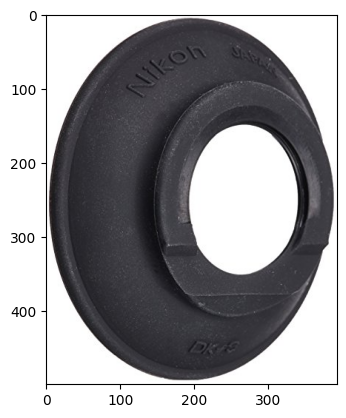

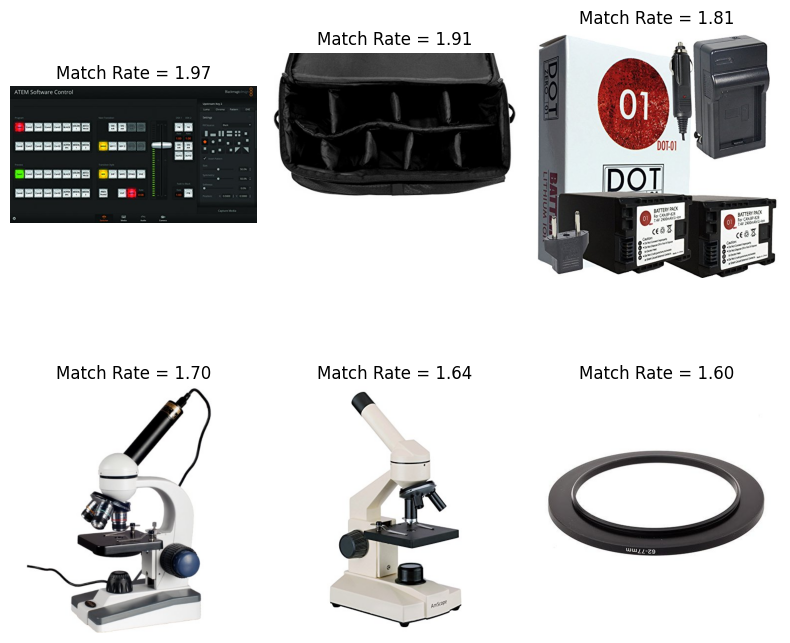

In [34]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 300  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(graph_loaded, node_id, loaded_model)
print("Recommended Product IDs:", recommended_products)

-----------------------------------------------------------------------
original product:
Recommended Product IDs: [(22956, 7.284826278686523), (19555, 6.097294330596924), (13909, 6.009315490722656), (12761, 5.507333755493164), (12180, 5.322539329528809), (272, 5.276097297668457)]


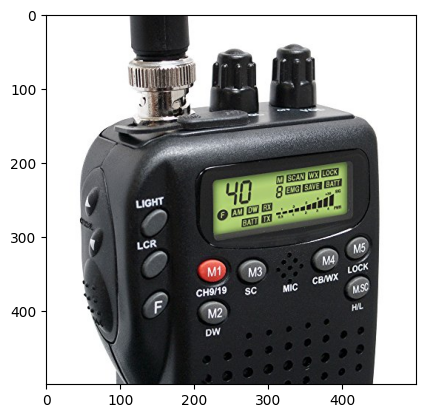

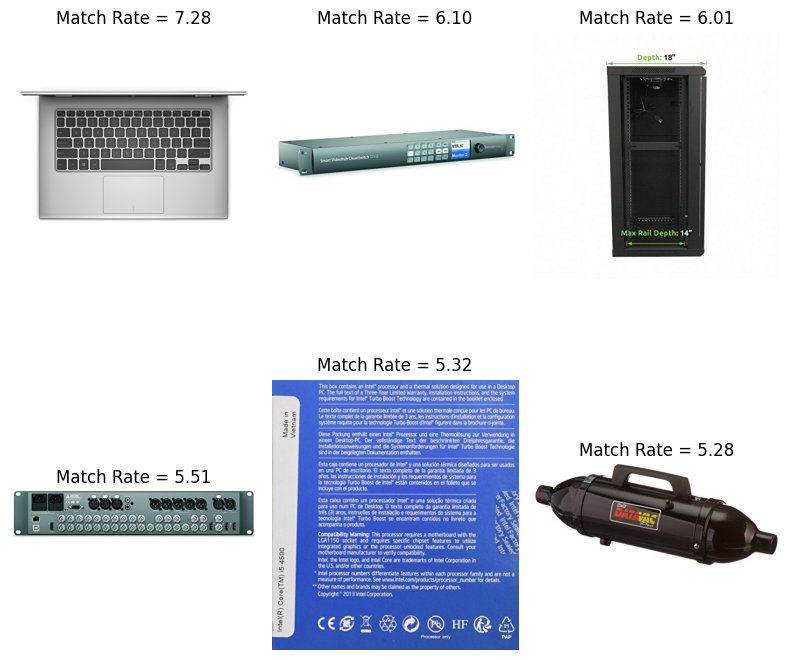

In [68]:
# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 40  # Example node ID
recommended_products = recommend_top_k_products_based_on_link_scores(g, node_id, model)
print("Recommended Product IDs:", recommended_products)

In [44]:
def compute_link_scores(graph, model, node_pairs=None):
    """
    Computes link prediction scores for node pairs using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - model: The trained GraphSAGE model.
    - node_pairs: A list of tuples, where each tuple represents a pair of node IDs.
                  If None, scores will be computed for all pairs of nodes in the graph.

    Returns:
    - Dictionary where keys are node pairs (tuples) and values are the link scores.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    
    # If no specific node pairs are provided, compute scores for all pairs
    if node_pairs is None:
        node_pairs = [(i, j) for i in range(graph.number_of_nodes()) for j in range(i+1, graph.number_of_nodes())]
    
    # Calculate link prediction scores
    link_scores = {}
    for u, v in node_pairs:
        # Compute score using dot product (you can use other scoring mechanisms like cosine similarity)
        score = torch.dot(node_embeddings[u], node_embeddings[v]).item()
        link_scores[(u, v)] = score
    
    return link_scores

# Example usage:
# Assuming `graph` is your existing graph and `model` is your trained GraphSAGE model.
# Compute link scores for all pairs of nodes
# link_scores = compute_link_scores(g, model)

# Optionally, compute link scores for specific pairs of nodes
specific_node_pairs = [(0, 1), (2, 3), (4, 5)]
specific_link_scores = compute_link_scores(g, model, specific_node_pairs)

# print("All Link Scores:", link_scores)
print("Specific Link Scores:", specific_link_scores)

Specific Link Scores: {(0, 1): 18.823564529418945, (2, 3): 1.468723177909851, (4, 5): 1.5798454284667969}


In [45]:
def recommend_top_k_unlinked_products(graph, node_id, model, k=5):
    """
    Recommends top K products that are not currently linked to the given node using link prediction scores.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Get the current neighbors of the node (i.e., products that are already bought)
    existing_edges = set(graph.successors(node_id).tolist())
    existing_edges.add(node_id)  # Exclude the node itself from being recommended
    
    # Calculate link prediction scores for the given node with all other unlinked nodes
    link_scores = []
    for other_node_id in range(graph.number_of_nodes()):
        # if other_node_id not in existing_edges:
        score = torch.dot(node_embedding, node_embeddings[other_node_id]).item()
        link_scores.append((other_node_id, score))
    
    # Sort the scores in descending order and get the top K
    link_scores.sort(key=lambda x: x[1], reverse=True)
    top_k_nodes = [node_id for node_id, score in link_scores[:k]]
    
    return (top_k_nodes,link_scores,node_embeddings)

# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 0  # Example node ID
top_k_nodes,link_scores,node_embeddings = recommend_top_k_unlinked_products(g, node_id, model, k=5)
print("Recommended Product IDs:", top_k_nodes)

Recommended Product IDs: [650, 280, 528, 529, 1027]


In [46]:
link_scores = []
for other_node_id in range(g.number_of_nodes()):
    # if other_node_id not in existing_edges:
    score = torch.dot(node_embeddings[842], node_embeddings[other_node_id]).item()
    link_scores.append((other_node_id, score))
link_scores.sort(key=lambda x: x[1], reverse=True)
top_k_nodes = [node_id for node_id, score in link_scores[:60]]
862 in top_k_nodes

False

In [47]:
scores = torch.cat([pos_score, neg_score]).numpy()
labels = torch.cat(
    [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()

In [48]:
scores

array([ 4.2493530e+01,  6.3516968e+02,  7.9914673e+01, ...,
       -4.7658050e-01, -4.2613826e+00,  1.3117288e+02], dtype=float32)

In [49]:
labels

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [50]:
# Function to make predictions
def predict(model, graph):
    model.eval()
    with torch.no_grad():
        output = model(graph, graph.ndata['feat'].float())
    return output
    
        # print(output)
        # return torch.argmax(output, dim=1)

In [51]:
output = predict(model,train_g)

In [52]:
output.shape

torch.Size([2283, 16])

In [53]:
new_node_id = train_g.number_of_nodes()

In [54]:
new_node_embedding = output[0]

In [55]:
train_g.edge_subgraph

<bound method edge_subgraph of Graph(num_nodes=2283, num_edges=3987,
      ndata_schemes={'feat': Scheme(shape=(2170,), dtype=torch.float32)}
      edata_schemes={})>

In [56]:
# Calculate scores for all product nodes based on similarity (e.g., cosine similarity)
product_embeddings = output[:-1]  # Assuming all nodes except the last one are products
scores = F.cosine_similarity(new_node_embedding.unsqueeze(0), product_embeddings)

# Get the top K product IDs based on the scores
top_k_indices = torch.topk(scores, 5).indices.tolist()

In [57]:
def recommend_top_k_products_for_node(graph, node_id, model, k=5):
    """
    Recommends top K products for a given node using a trained GraphSAGE model.

    Parameters:
    - graph: The DGL graph.
    - node_id: The ID of the node for which recommendations are to be made.
    - model: The trained GraphSAGE model.
    - k: Number of top products to recommend (default is 5).

    Returns:
    - List of recommended product node IDs.
    """
    
    # Compute node embeddings for the entire graph
    model.eval()
    with torch.no_grad():
        node_embeddings = model(graph, graph.ndata['feat'])
    return node_embeddings
    # Extract the embedding of the given node
    node_embedding = node_embeddings[node_id]
    
    # Calculate scores for all product nodes based on similarity (e.g., cosine similarity)
    scores = F.cosine_similarity(node_embedding.unsqueeze(0), node_embeddings)
    
    # Mask the score of the given node to avoid recommending the node itself
    scores[node_id] = float('-inf')
    
    # Get the top K product IDs based on the scores
    top_k_indices = torch.topk(scores, k).indices.tolist()
    
    return top_k_indices

# Example usage:
# Assuming `graph` is your existing graph, `node_id` is the ID of the node to get recommendations for,
# and `model` is your trained GraphSAGE model.
node_id = 0  # Example node ID
recommended_products = recommend_top_k_products_for_node(train_g, node_id, model, k=5)
print("Recommended Product IDs:", recommended_products)

Recommended Product IDs: tensor([[-0.6300, -2.7456, -0.2526,  ...,  0.6590,  1.4635,  2.0644],
        [-0.7898, -1.7645, -2.0017,  ...,  0.7580,  1.3173,  0.9929],
        [-0.7478,  1.0193, -5.6654,  ...,  1.0686,  4.1647,  2.9371],
        ...,
        [-3.0009, -5.8526, -4.6380,  ...,  0.2716,  3.2869,  3.7501],
        [ 0.5255,  0.6251,  0.7182,  ..., -0.2606,  0.3065,  0.1514],
        [ 0.5255,  0.6251,  0.7182,  ..., -0.2606,  0.3065,  0.1514]])


In [58]:
recommended_products[0]

tensor([-0.6300, -2.7456, -0.2526,  1.3935, -2.6034,  1.4873, -2.1911,  2.5289,
         0.6673, -0.4867,  0.3065,  0.3598, -0.2743,  0.6590,  1.4635,  2.0644])

In [59]:
nodes.loc[111].title

'Celestron Erect Image Prism for Refractor and Schmidt Cassegrain'

In [60]:
output.shape

torch.Size([2283, 16])

In [61]:
torch.arg(output, dim=1)

AttributeError: module 'torch' has no attribute 'arg'

In [ ]:
text_df = nodes[['title','niche']]
# text_df.asin = text_df.asin.apply(lambda x: asin_map[x])
# text_df = text_df.drop_duplicates('asin').reset_index(drop=True)
text_df = text_df.sort_index().reset_index()
print('nodes',nodes.shape)

#TF-IDF Vectorizer for Title Text Feature

corpus = list(text_df.title)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.toarray()

nodes (82, 20)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.24191687, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
img_feature = []
for i in nodes.asin:
    img_feature.append(extract_vectors(f'./processed/images/{i}/1.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [ ]:
X.toarray().shape

(82, 704)

In [ ]:
np.hstack((X.toarray(),np.array(img_feature))).shape

(82, 2752)

In [ ]:
np.array(img_feature).shape

(82, 2048)

In [ ]:
df_full_explode = df_full.copy()
df_full_explode = df_full_explode.explode('also_buy')
# df_full_explode = df_full_explode[(df_full_explode.also_buy.isin(df_full.asin)) | (df_full_explode.also_buy.isna()) ]
df_full_explode.also_buy = np.where(df_full_explode.also_buy.isin(final_list),df_full_explode.also_buy,np.nan)
df_full_explode = df_full_explode.drop_duplicates(['asin','also_buy'])
df_full_explode.shape

(265278, 20)

In [ ]:
sample_df = df_full_explode[~df_full_explode['also_buy'].isna()].head(100)

In [ ]:

edges = sample_df[['asin', 'also_buy']].drop_duplicates(['asin', 'also_buy'])
all_nodes = list(edges.asin) + list(edges.also_buy)
all_nodes = list(set(all_nodes))
#Map String ASINs (IDs) to Int IDs
asin_map_dict = pd.Series(all_nodes).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

edges['asin'] = edges.asin.apply(lambda x: asin_map[x])
edges['also_buy'] = edges.also_buy.apply(lambda x: asin_map[x])
edges = edges.sort_values(['asin'])
edges = edges.reset_index(drop=True)
# all_nodes = list(edges.asin) + list(edges.also_buy)
# all_nodes = list(set(all_nodes))
edges.shape


(100, 2)

In [ ]:
len(all_nodes)

109

In [ ]:
nodes = df_full[df_full.asin.isin(all_nodes)]
nodes['asin_mapped'] = nodes.asin.apply(lambda x: asin_map[x])
nodes = nodes.set_index('asin_mapped').sort_index()
nodes.shape

(109, 20)

In [ ]:
#Text Manipulations
text_df = nodes[['title','niche']]
# text_df.asin = text_df.asin.apply(lambda x: asin_map[x])
# text_df = text_df.drop_duplicates('asin').reset_index(drop=True)
text_df = text_df.sort_index().reset_index()

In [ ]:
#TF-IDF Vectorizer for Title Text Feature
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = list(text_df.title)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
X.toarray().shape



(109, 604)

In [ ]:
text_df.shape

(109, 3)

In [ ]:
node_features = torch.Tensor(X.toarray())
node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())
edges_src = torch.from_numpy(edges['asin'].to_numpy())
edges_dst = torch.from_numpy(edges['also_buy'].to_numpy())

In [ ]:
node_features.shape

torch.Size([109, 604])

In [ ]:
len(edges_src)

100

In [ ]:


#Build Graph
g = dgl.graph((edges_src, edges_dst))
g.ndata['feat'] = node_features
g.ndata['label'] = node_labels

In [ ]:
from tqdm import tqdm
# from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [ ]:
df_full_explode.also_buy.isin(final_list)

index
37        False
37         True
63        False
63         True
63         True
          ...  
786402     True
786402     True
786402     True
786402     True
786402     True
Name: also_buy, Length: 265278, dtype: bool

In [ ]:
df_full['also_buy_new'] = df_full['also_buy'].progress_apply(lambda x: set(df_full.asin).intersection(x))

  0%|          | 122/35511 [00:00<01:34, 374.08it/s]

 73%|███████▎  | 26052/35511 [01:22<00:30, 315.12it/s]


KeyboardInterrupt: 

<Axes: xlabel='also_buy_new'>

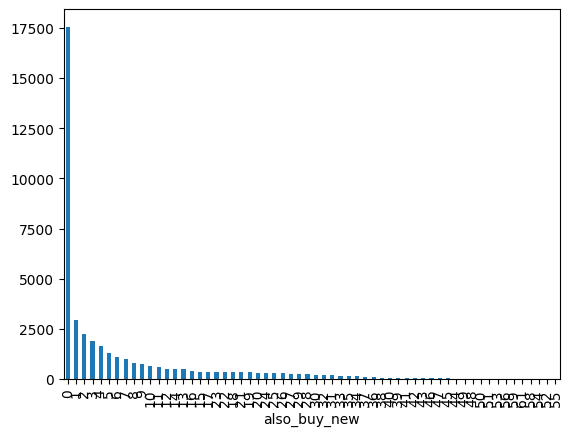

In [ ]:
df_full['also_buy_new'].str.len().value_counts().plot.bar()

In [ ]:
len(final_list)

39250

In [ ]:
df_full_explode.also_buy_new.nunique()

33534

In [ ]:
df_full_explode.asin.nunique()

39250

In [ ]:
edges.to_clipboard()

In [ ]:
df_full_explode.also_buy_new.isna().sum()

17564

In [ ]:
edges

,asin,also_buy_new
0,15691,1797
1,27965,28905
2,27965,24855
3,27965,4407
4,27965,4710
...,...,...
237696,25295,26158
237697,25295,32719
237698,25295,12495
237699,25295,10476


In [ ]:
temp = []
for i in df.also_buy:
    temp+=i

In [ ]:
d

In [ ]:
final_list = list((set(temp) & set(unique_id)))

In [ ]:
df[df.asin=='B00EB179ZI']

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
index,,,,,,,,,,,,,,,,,,,
406044,"[Electronics, GPS, Finders & Accessories, GPS ...",,[Replacement part for Pioneer Power w/Speaker ...,,Xtenzi Power Cord Harness speaker Plug For Pio...,"[B005EVDRZA, B004BBNBM8, B004C4U6RM, B06WLPYN9...",,Xtenzi,[Xtenzi Brand Replacement indash radio Replace...,['>#47 in Electronics > Accessories & Supplies...,[],All Electronics,"class=""a-bordered a-horizontal-stripes a-spa...","August 3, 2013",$2.00,B00EB179ZI,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}


In [ ]:
df = df[df.asin.isin(final_list)]

In [ ]:
len(final_list)

22565

In [ ]:
df['main_cat'].value_counts().to_frame()

,count
main_cat,
Computers,8712
All Electronics,5640
Home Audio & Theater,3073
Cell Phones & Accessories,2914
Camera & Photo,2772


In [ ]:
df['also_buy_new'] = df['also_buy'].apply(lambda x: set(df.asin).intersection(x))

In [ ]:
df['also_buy_new'].str.len().describe()

In [ ]:
df.also_buy

index
7         [B01NAJ3KQB, B00WYSPT0C, B00AF40U5G, B00OFVNM4...
37                                 [B06VTZK822, B00OSI6O7S]
38                                             [B000BUQOGI]
57        [B00E9IKYKK, 1400699169, B00E9ISXPS, B00ZOONDP...
63        [B00940BV1Y, B00RRFMVEE, B0032UP32K, B01MYQWLT...
                                ...                        
786421                 [B002Q907EW, B00HSF65MC, B009VCZ4V8]
786423    [B00IVPU786, B01DOB6Y5Q, B010Q57T02, B01M592J9...
786424                             [B01HJCN55I, B01D6IEG6Q]
786433                                         [B01M096I7Q]
786444                                         [B00Z7SAZXC]
Name: also_buy, Length: 66217, dtype: object

In [ ]:
df[df['asin']=='B00OSI6O7S']

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
index,,,,,,,,,,,,,,,,,,,
556752,"[Electronics, Accessories & Supplies, Audio & ...",,[],,Clikr-5 Time Warner Cable Remote Control Ur5u-...,"[B06VTZK822, B077Y8QWRQ, 0511189877, B00KUL8O0...",,Time Warner Cable,[],"['>#1,585 in Electronics > Accessories & Suppl...",[],Home Audio & Theater,"class=""a-bordered a-horizontal-stripes a-spa...","October 22, 2014",$2.00,B00OSI6O7S,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,{}


In [ ]:
df.asin

index
7         0101635370
37        0511189877
38        0528013475
57        0594450268
63        0594296420
             ...    
786421    B01HJDXFQQ
786423    B01HJDNL60
786424    B01HJCN5GC
786433    B01HJFRHYA
786444    B01HJH42KU
Name: asin, Length: 66217, dtype: object

In [ ]:
asin_map_dict = pd.Series(edges.asin.append(edges.also_bought).unique()).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

AttributeError: 'Series' object has no attribute 'append'

In [ ]:
# Load and preprocess image
img_path = './Logo.png'
features = extract_vectors(img_path)
print("Shape of extracted features:", features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Shape of extracted features: (2048,)


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
x = base_model.layers[-2].output 
faster_rcnn_model = Model(inputs=base_model.input, outputs=x)


In [ ]:
faster_rcnn_model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


array([[0.46364686, 0.48424578, 0.06289104, ..., 0.16605212, 0.0654472 ,
        0.5422633 ]], dtype=float32)

In [ ]:
features

array([0.46364686, 0.48424578, 0.06289104, ..., 0.16605212, 0.0654472 ,
       0.5422633 ], dtype=float32)

In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
base_model.input

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=None, name=keras_tensor>

In [ ]:
# Load pre-trained ResNet50 model without top (classification) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Define Faster R-CNN architecture on top of ResNet50 backbone
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce spatial dimensions
faster_rcnn_model = Model(inputs=base_model.input, outputs=x)




# Load and preprocess image
img_path = './Logo.png'
img = keras_image.load_img(img_path, target_size=(224, 224))
img_array = keras_image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Extract features using Faster R-CNN model
features = faster_rcnn_model.predict(img_array)
features = features.flatten()
print("Shape of extracted features:", features.shape)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 224, 3), dtype=float32). Expected shape (None, None, None, 3), but input has incompatible shape (32, 224, 3)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 224, 3), dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Load and preprocess image
img_path = './Logo.png'
img = keras_image.load_img(img_path, target_size=(224, 224))
img_array = keras_image.img_to_array(img)


In [ ]:
img_array.shape

(224, 224, 3)

In [ ]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 224, 224, 3)

In [ ]:
img_array = preprocess_input(img_array)
img_array.shape

(1, 224, 224, 3)